# Assignment 2 EE21S061 by Arihant Jain

## Importing Library

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import sys
import numpy as np
import os
import torchvision.datasets as datasets

from torchsummary import summary
import matplotlib.pyplot as plt

## loading dataset and utility function

Here i have added function to convert the target label into one hot encoding and also normalize image pixels.

In [4]:
import torch.nn.functional as F

def one_hot(x):
    temp = torch.zeros(10)
    temp[x] = 1
    return temp

def transform(x):
    return np.asarray(x) / 255


mnist_trainset = datasets.MNIST(root='./data', train = True , download=True, target_transform = one_hot, transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.1307,), (0.3081,))]))
mnist_testset = datasets.MNIST(root='./data', train = False ,download=True,target_transform = one_hot, transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.1307,), (0.3081,))]))


In [5]:
mnist_testset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
Target transform: <function one_hot at 0x7f3e61c87430>

In [6]:
# cpu-gpu
a = torch.randn((3, 4))
print(a.device)

device = torch.device("cuda")
a = a.to(device)
print(a.device)

# a more generic code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cpu
cuda:0


In [7]:
!nvidia-smi

Sun Sep 25 20:43:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:09:00.0 Off |                  N/A |
|  0%   40C    P2   109W / 350W |   1829MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
print(f"# of train samples: {len(mnist_trainset)}")
print(f"# of test samples: {len(mnist_testset)}")

# of train samples: 60000
# of test samples: 10000


In [9]:
train_loader = DataLoader(mnist_trainset, batch_size=100, shuffle=True, num_workers=2)
test_loader = DataLoader(mnist_testset, batch_size=100, shuffle=False, num_workers=2)

In [10]:
print(f"# of train batches: {len(train_loader)}")
print(f"# of test batches: {len(test_loader)}")

# of train batches: 600
# of test batches: 100


In [11]:
print("sample i/o sizes")
data = next(iter(train_loader))
img, target = data
print(f"input size: {img.shape}")
print(f"output size: {target.shape}")

sample i/o sizes
input size: torch.Size([100, 1, 28, 28])
output size: torch.Size([100, 10])


## Model:

* Defining the model as mentioned in the question. I have also added a function to get out from the layers before the softmax to work on the adversial examples.

In [12]:
class MNISTCNN(nn.Module):
    
    
    def __init__(self):
        super(MNISTCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3,padding = 1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3,padding = 1)
        self.fc1   = nn.Linear(1568, 500)
        self.fc2   = nn.Linear(500, 10)
        self.activ = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def pool(self, x, kernel_size=2,stride=2):
        out = F.max_pool2d(x,kernel_size,stride=2)
        return out

    def forward(self, x):

        out = self.activ(self.conv1(x))
        out = self.pool(out)
        out = self.activ(self.conv2(out))
        out = self.pool(out)

        out = out.view(out.size(0),-1)
        out = self.activ(self.fc1(out))
        out = self.fc2(out)
        out = self.softmax(out)
        return out
    
    def logits(self, x):
        
        out = self.activ(self.conv1(x))
        out = self.pool(out)
        out = self.activ(self.conv2(out))
        out = self.pool(out)

        out = out.view(out.size(0),-1)
        out = self.activ(self.fc1(out))
        out = self.fc2(out)
        
        return out
        


In [13]:
temp = MNISTCNN()
train_features, train_labels = next(iter(train_loader))

In [14]:
print(temp.forward(train_features)[0])
print(train_labels[0])

tensor([0.1085, 0.0943, 0.1046, 0.0960, 0.0890, 0.1001, 0.1017, 0.1104, 0.0960,
        0.0994], grad_fn=<SelectBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])


The network is currently predicting randomly we need to train it. Using function from the tutorial to show the training and progress.

In [17]:
def pbar(p=0, msg="", bar_len=20):
    sys.stdout.write("\033[K")
    sys.stdout.write("\x1b[2K" + "\r")
    block = int(round(bar_len * p))
    text = "Progress: [{}] {}% {}".format(
        "\x1b[32m" + "=" * (block - 1) + ">" + "\033[0m" + "-" * (bar_len - block),
        round(p * 100, 2),
        msg,
    )
    print(text, end="\r")
    if p == 1:
        print()


class AvgMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.metrics = {}

    def add(self, batch_metrics):
        if self.metrics == {}:
            for key, value in batch_metrics.items():
                self.metrics[key] = [value]
        else:
            for key, value in batch_metrics.items():
                self.metrics[key].append(value)

    def get(self):
        return {key: np.mean(value) for key, value in self.metrics.items()}

    def msg(self):
        avg_metrics = {key: np.mean(value) for key, value in self.metrics.items()}
        return "".join(["[{}] {:.5f} ".format(key, value) for key, value in avg_metrics.items()])

In [18]:
def train(model, optim, lr_sched=None, epochs=200, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"), criterion=None, metric_meter=None, out_dir="out/"):
  model.to(device)
  best_acc = 0
  valid_loss = []
  test_acc = []
  train_loss = []
  for epoch in range(epochs):
    model.train()
    metric_meter.reset()
    for indx, (img, target) in enumerate(train_loader):
      img = img.to(device)
      target = target.to(device)

      out = model(img)
      loss = criterion(out, target)
      optim.zero_grad()
      loss.backward()
      optim.step()
      metric_meter.add({"train loss": loss.item()})
      train_loss.append(loss.item())
      pbar(indx / len(train_loader), msg=metric_meter.msg())
    pbar(1, msg=metric_meter.msg())

    model.eval()
    metric_meter.reset()
    for indx, (img, target) in enumerate(test_loader):
      img = img.to(device)
      target = target.to(device)
      out = model(img)
      loss = criterion(out, target)
      acc = (out.argmax(1) == target.argmax(1)).type(torch.float).sum().item()

      metric_meter.add({"test loss": loss.item(), "test acc": acc})
      valid_loss.append(loss.item())
      test_acc.append(acc)
      pbar(indx / len(test_loader), msg=metric_meter.msg())
    pbar(1, msg=metric_meter.msg())
    
    test_metrics = metric_meter.get()
    if test_metrics["test acc"] > best_acc:
      print(
          "\x1b[33m"
          + f"test acc improved from {round(best_acc, 5)} to {round(test_metrics['test acc'], 5)}"
          + "\033[0m"
      )
      best_acc = test_metrics['test acc']
      torch.save(model.state_dict(), os.path.join(out_dir, "best.ckpt"))
    lr_sched.step()
  return (train_loss,valid_loss,test_acc)

In [19]:
model = MNISTCNN()
model_name = "MNISTCNN"
out_dir = f"{model_name}"

epochs = 20
optim = torch.optim.SGD(model.parameters(), lr=2e-1, momentum=0.9, weight_decay=7e-4)
lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=epochs)
criterion = nn.CrossEntropyLoss()
metric_meter = AvgMeter()
os.makedirs(out_dir, exist_ok=True)
metric_plot = train(model, optim, lr_sched, epochs=epochs, criterion=criterion, metric_meter=metric_meter, out_dir=out_dir)

# model.load_state_dict(torch.load(out_dir + "/best.ckpt"))

Progress: [===================>] 100% [train loss] 1.83432 2 
Progress: [===================>] 100% [test loss] 1.50250 [test acc] 95.96000  
test acc improved from 0 to 95.96
Progress: [===================>] 100% [train loss] 1.49606 6 
Progress: [===================>] 100% [test loss] 1.48600 [test acc] 97.62000  
test acc improved from 95.96 to 97.62
Progress: [===================>] 100% [train loss] 1.48891 1 
Progress: [===================>] 100% [test loss] 1.47940 [test acc] 98.37000  
test acc improved from 97.62 to 98.37
Progress: [===================>] 100% [train loss] 1.48567 7 
Progress: [===================>] 100% [test loss] 1.48310 [test acc] 97.94000  
Progress: [===================>] 100% [train loss] 1.48428 8 
Progress: [===================>] 100% [test loss] 1.49064 [test acc] 97.45000  
Progress: [===================>] 100% [train loss] 1.48288 8 
Progress: [===================>] 100% [test loss] 1.48209 [test acc] 98.14000  
Progress: [===================>] 100% 

### Plots for Training Loss, Testing Loss and Accuracy through the iteration

* We can see the model starts with a very high accuracy from the beginning and this can be viewed from each of the graph as well.

* The model then just tries to achieve does few points of accuracy over the rest of the epoch and try to basically optimize itself but what its doing is just moving around in a local minima and the model is pretty much settled in.

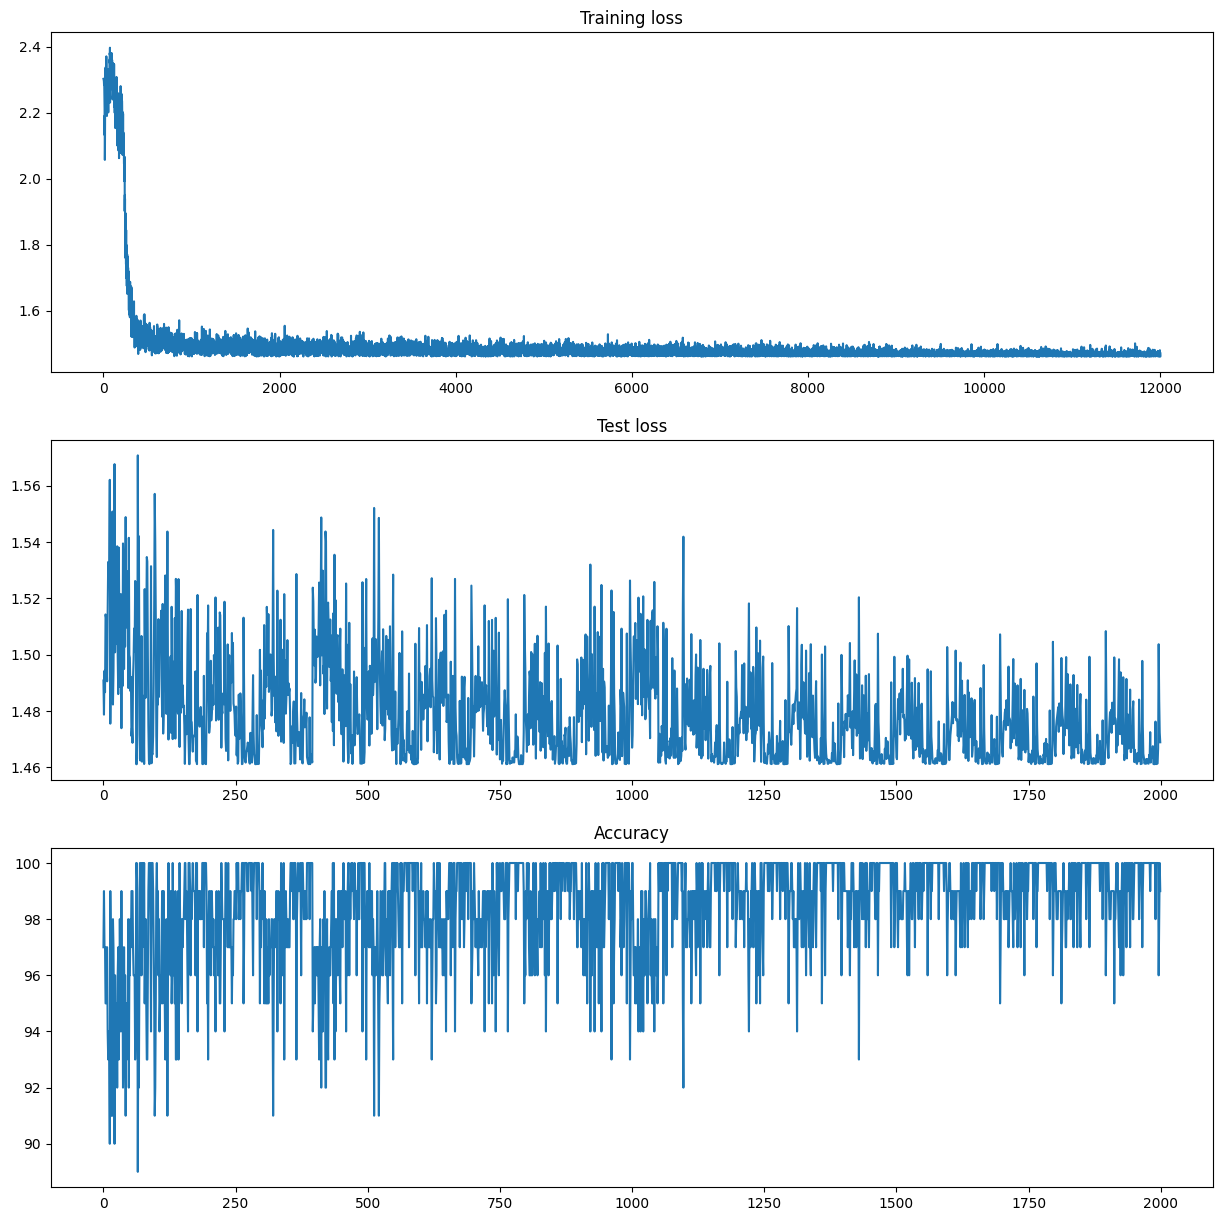

In [20]:
import matplotlib.pyplot as plt
fig , (train,valida,acc) =  plt.subplots(3,1,figsize=(15, 15))
train.plot(metric_plot[0])
train.title.set_text("Training loss")


valida.plot(metric_plot[1])
valida.title.set_text("Test loss")

acc.plot(metric_plot[2])
acc.title.set_text("Accuracy")

### Summary of the model and all the parameters in each of the layers. 

In [216]:
model.forward

<bound method MNISTCNN.forward of MNISTCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (activ): ReLU()
  (softmax): Softmax(dim=1)
)>

* We can see the summary of the model above this gives us a few into the structure of the model and shows the indivually hyperparameter for each layer their stride padding and more.

* Looking further into these we can see the number of trainable parameter below and how the layers are connected in sequence.

In [217]:
summary(model,input_size=(1, 28, 28),device = 'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 32, 14, 14]           9,248
              ReLU-4           [-1, 32, 14, 14]               0
            Linear-5                  [-1, 500]         784,500
              ReLU-6                  [-1, 500]               0
            Linear-7                   [-1, 10]           5,010
           Softmax-8                   [-1, 10]               0
Total params: 799,078
Trainable params: 799,078
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.49
Params size (MB): 3.05
Estimated Total Size (MB): 3.54
----------------------------------------------------------------


* We can see how most of the parameter in the final Fully Connected Layer. To put in prespective if we calculate the percentage of paramter it comes out to be 98% of parameters are in the Fully Connected Layer of the model.

* Convulation Layer has very few number of parameters.which are the kernel we have trained to divide the channel in the input image to extract feature.

* ReLu and Pool or Softmax do not have any trainable parameters.

In [23]:
test_features, test_labels = next(iter(test_loader))
test_features = test_features.cpu()

### Visualizing the Prediction from the Trained model and checking with the True label. 

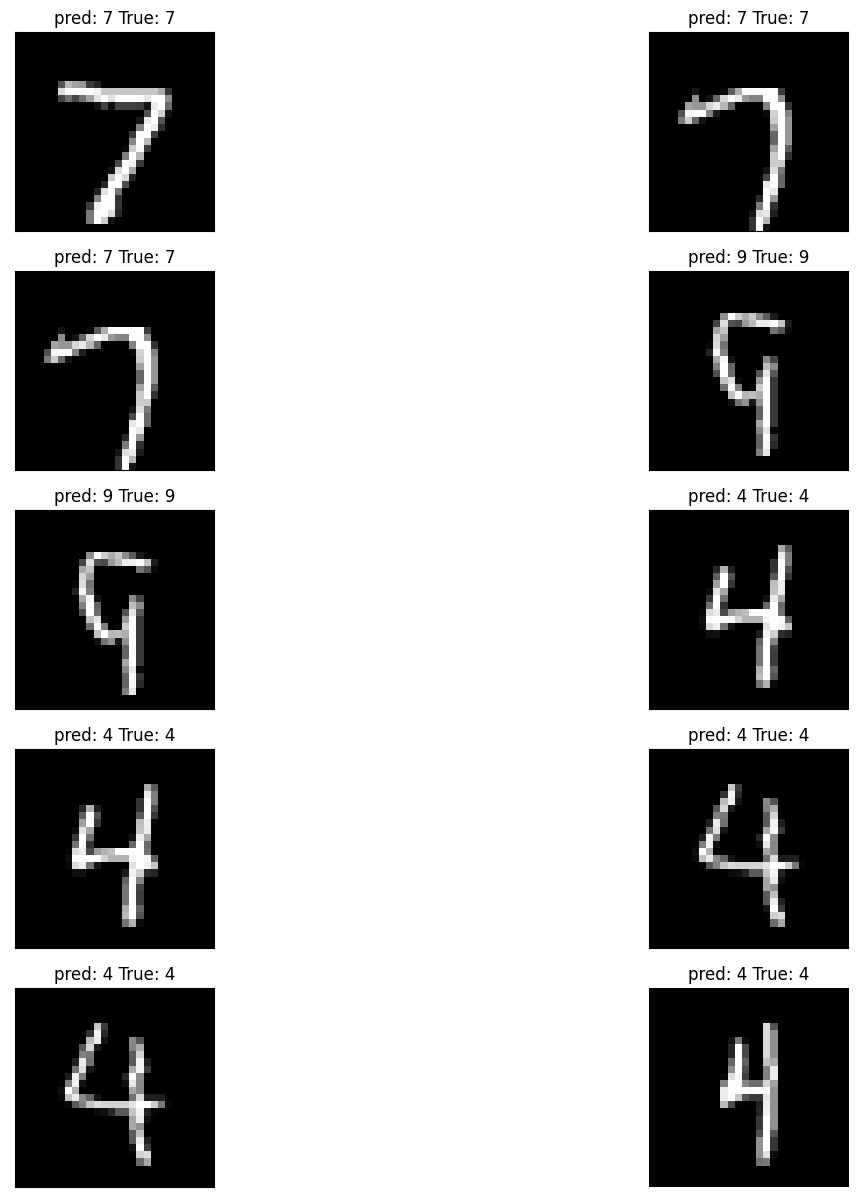

In [206]:
import matplotlib.pyplot as plt
fig , axs = plt.subplots(5,2,figsize=(15, 15))
k=0
plt.axis('off')
rand_samples = np.random.choice(test_features.shape[0],10)
for i in range(5):
    for j in range(2):
        axs[k,j].xaxis.set_visible(False)
        axs[k,j].yaxis.set_visible(False)
        axs[k,j].imshow(test_features[rand_samples[i]][0,:,:],  cmap="gray")
        axs[k,j].title.set_text("pred: " + str(model(test_features.cpu())[rand_samples[i]].argmax().item()) + " True: " + str(test_labels[rand_samples[i]].argmax().item()))
        i+=1
    k+=1

# Q2. Lets look at the convulation kernel trained from the network

In [21]:
no_of_layers=0
conv_layers=[]

model_children=list(model.children())

for child in model_children:
  if type(child)==nn.Conv2d:
    no_of_layers+=1
    conv_layers.append(child)
print(no_of_layers)

2


## Convulation Layer 1

* The first layer has 32 kernel for each of the out dimension these are the low level feature extraction these filter or kernel are looking for edges and various pattern accross the images.

* we can see from the plot below the observed pattern are relatively simple.

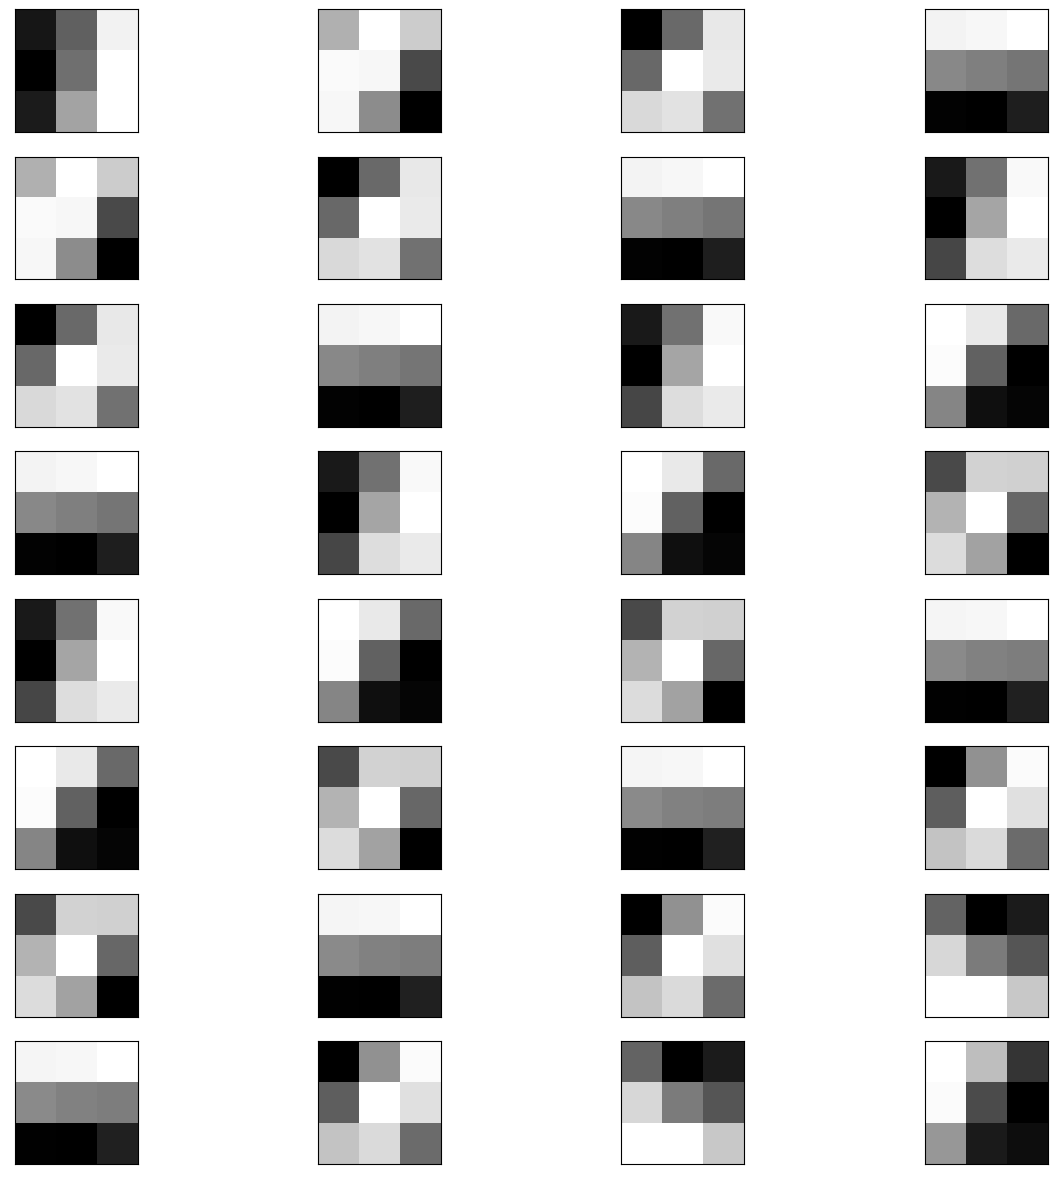

In [25]:
fig , axs = plt.subplots(8,4,figsize=(15, 15))
k=0
for i in range(8):
    for j in range(4):
        axs[k,j].xaxis.set_visible(False)
        axs[k,j].yaxis.set_visible(False)
        axs[k,j].imshow(conv_layers[0].weight[i].cpu().detach().numpy().reshape(3,3),  cmap="gray")
        i+=1
    k+=1

In [29]:
conv_layers[1].weight[0][0].shape

torch.Size([3, 3])

## Convulation Layer 2

* We created 32 dimension from the original 1 dimension our second convulation layer adds to this and take 32 channel and outputs 32 different channel these are second layer channel and are supposed to be more specific.

* Given the size 3X3 for each kernel we can see the image of that size is not big enough for us to visualize what exactly is the model training for but these feature are extracted from the feature which were already highlighted by the 1st layer of convolution.

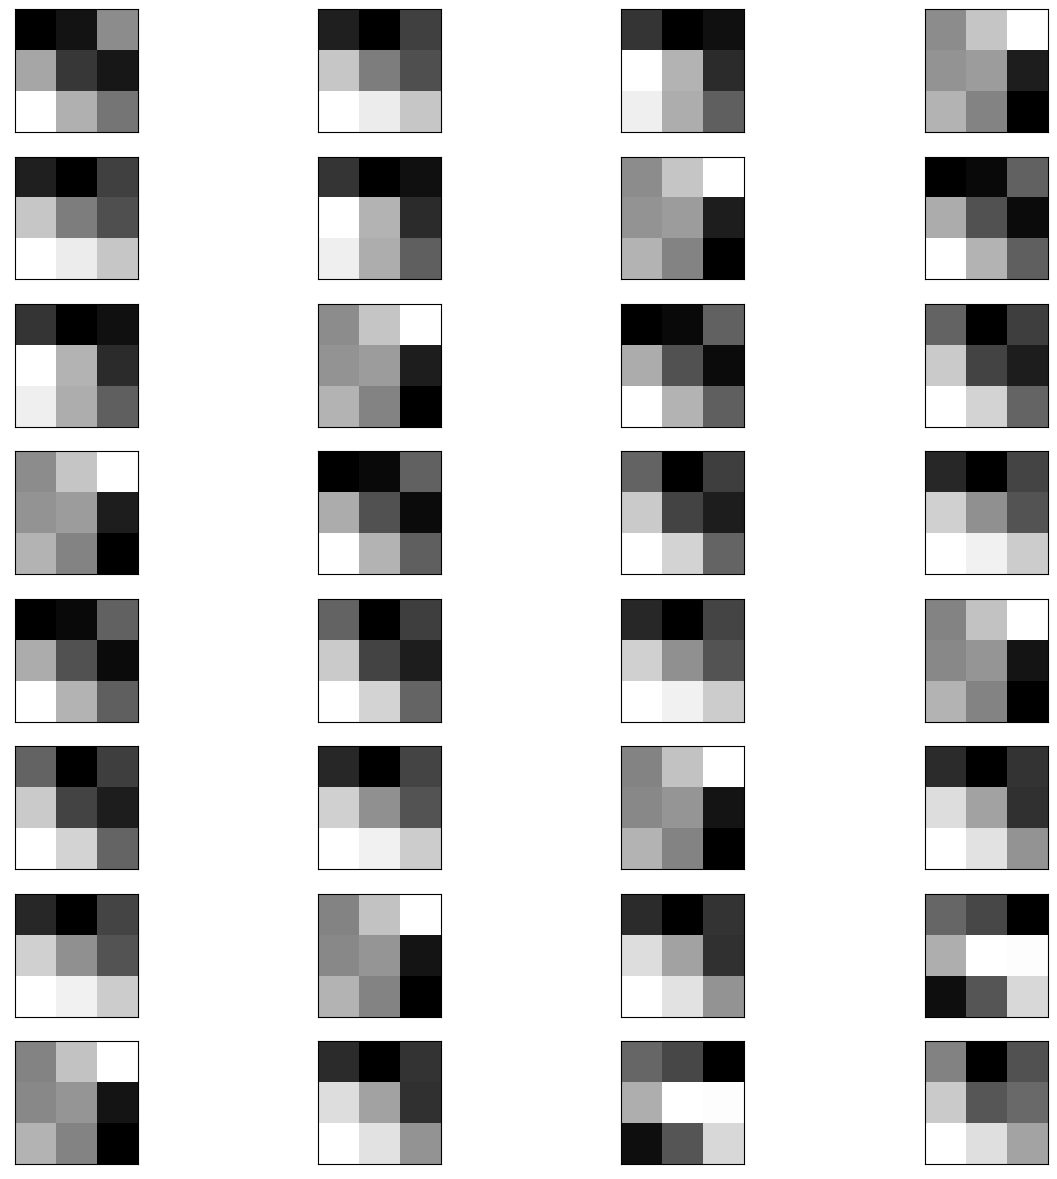

In [30]:
fig , axs = plt.subplots(8,4,figsize=(15, 15))
k=0
l=3  # for the layer 3
for i in range(8):
    for j in range(4):
        axs[k,j].xaxis.set_visible(False)
        axs[k,j].yaxis.set_visible(False)
        axs[k,j].imshow(conv_layers[1].weight[l][i].cpu().detach().numpy().reshape(3,3),  cmap="gray")
        i+=1
    k+=1

## Occluding part of image:

* In this section we will be putting a manual block of grey pixel on top the original image and measure how the confidence or prediction of the model various as we pass this patch over the length and width of the image.

* This would let us see what is being observed by the model to actually figure out which digit is in the image.

* We assume since a lot of space is just black pixel this would not be an issue or that part of the image. Lets see.

In [79]:
test_features, test_labels = next(iter(test_loader))
rand_samples = np.random.choice(test_features.shape[0],10)

0.9999324083328247


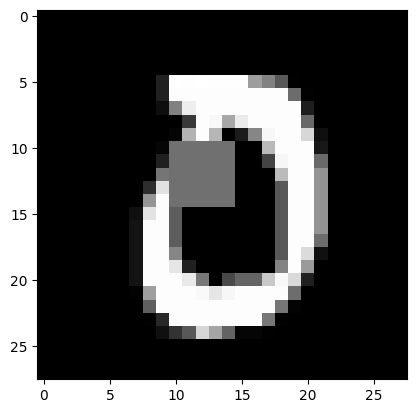

In [81]:
i = 0

x=y=10

siz = 5

temp = torch.clone(test_features[rand_samples[i]].cpu().reshape(28,28))
temp[x:x+siz,y:y+siz] = torch.from_numpy(np.full((siz,siz),1))

plt.imshow(temp,cmap='gray')
print(model.forward(temp.reshape(1,1,28,28).cpu())[0][test_labels[rand_samples[i]].argmax().item()].item())

### Patch size 7X7

* Keeping the patch size fixed we sample a bunch of data from the test dataset and then we will be plotting the confidence of the model for the true label of that sample as the patch moves over the image.

* This would give us a 2-D plot for each image and let us see for which position of the patch does the confidence vary.

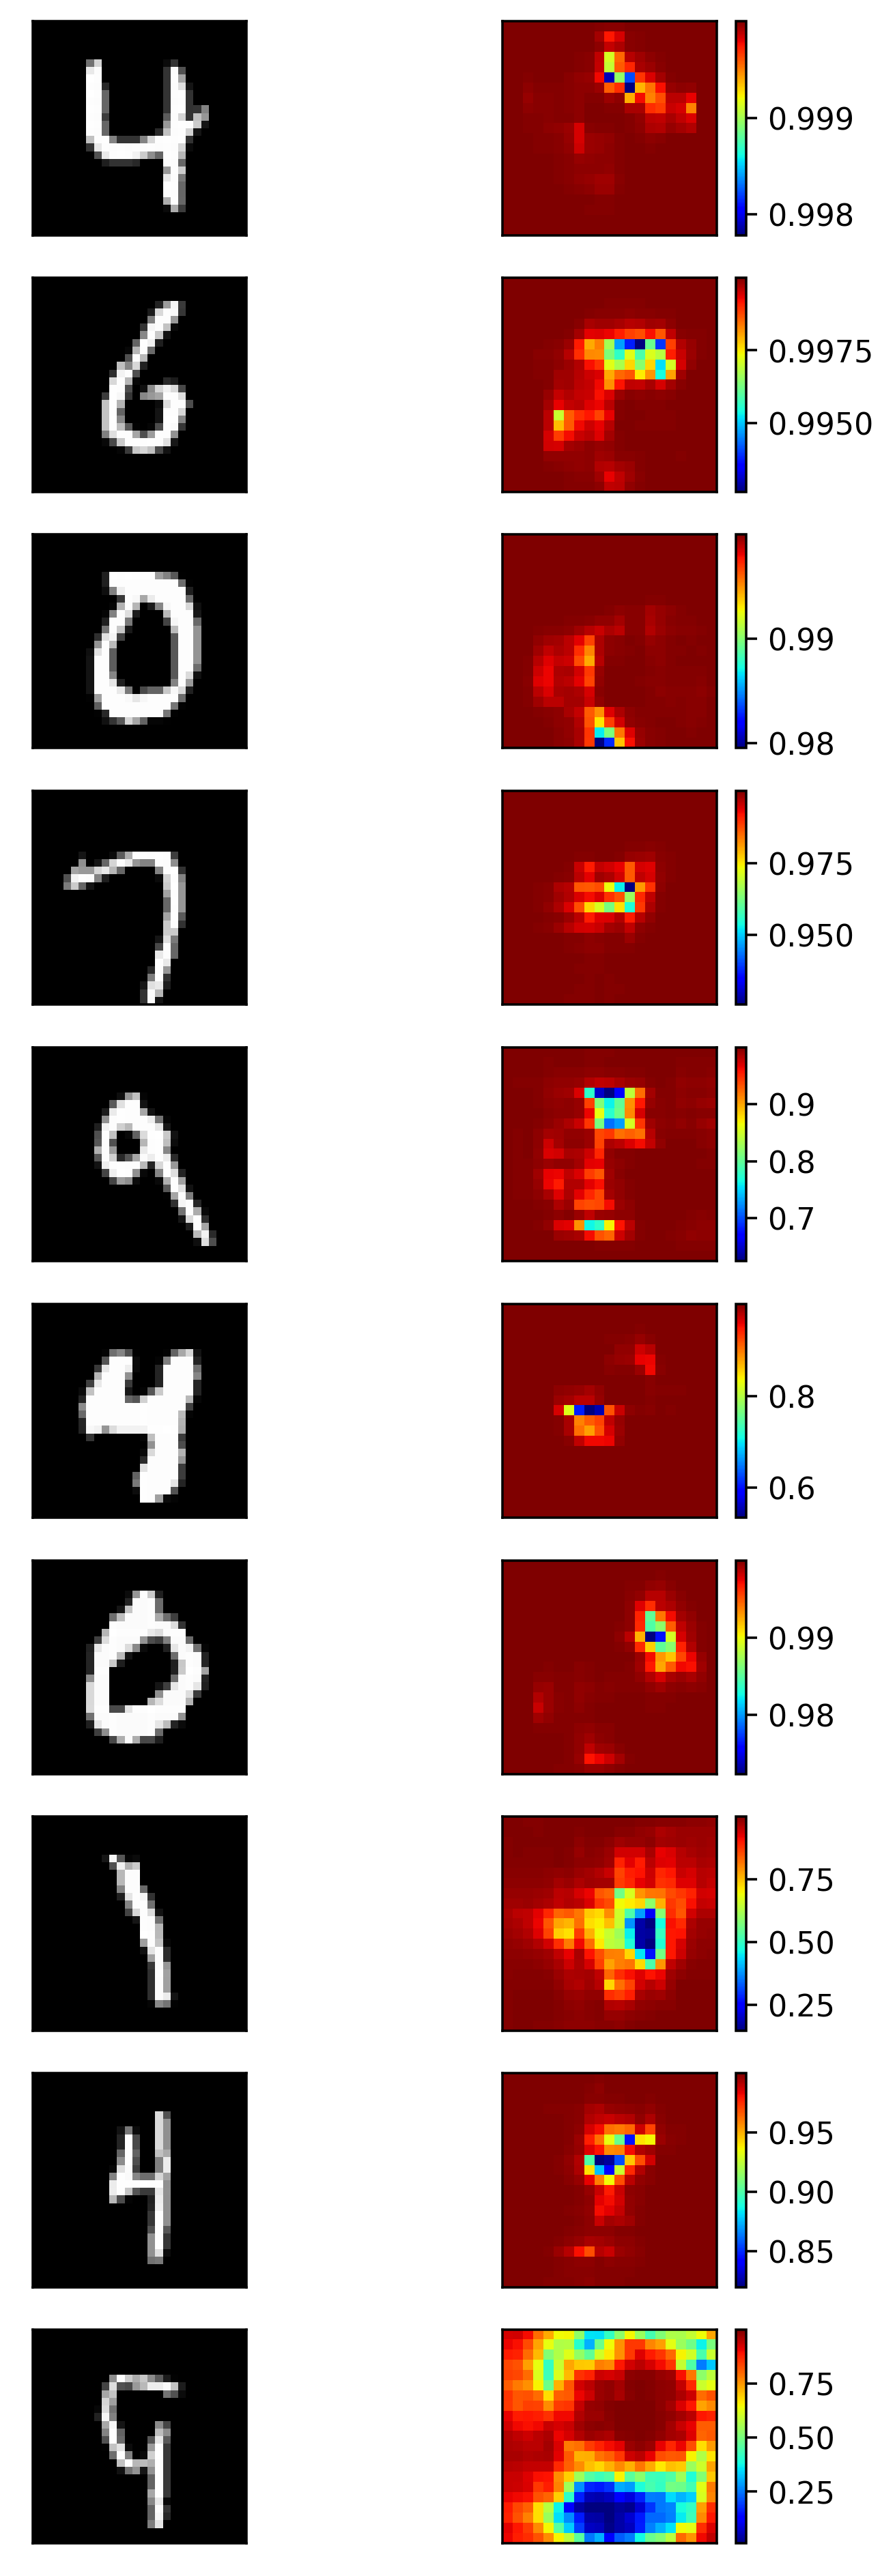

In [87]:
test_features, test_labels = next(iter(test_loader))
rand_samples = np.random.choice(test_features.shape[0],10)
siz = 7
prob = np.zeros((len(range(0,28-siz)),len(range(0,28-siz)),10))

for i in range(0,28-siz):
    for j in range(0,28-siz):
        for k in range(10):
            temp = torch.clone(test_features[rand_samples[k]].reshape(28,28))
            temp[i:i+siz,j:j+siz] = torch.from_numpy(np.full((siz,siz),1))
            prob[i,j,k]=model.forward(temp.reshape(1,1,28,28).cpu())[0][test_labels[rand_samples[k]].argmax().item()].item()
fig , axs = plt.subplots(10,2,figsize=(5, 15),dpi=320)
k=0
for i in range(10):
    
    axs[i,0].xaxis.set_visible(False)
    axs[i,0].yaxis.set_visible(False)
    axs[i,0].imshow(test_features[rand_samples[i]].reshape(28,28),  cmap="gray")
    axs[i,1].xaxis.set_visible(False)
    axs[i,1].yaxis.set_visible(False)
    im = axs[i,1].imshow(prob[:,:,i],cmap='jet')
    plt.colorbar(im, ax = axs[i,1])
k+=1

#### Results:

* In this experiment we see that some digits are not much susceptible to this type of occulusion as we can see with digits for 1, 4 or 0.

* In the last image for 9 we see a lot of movement of the heatmap we see confidence of the model go as low as 20% if patch hides the lower line of the digit and also we have more loss in confidence compared to other digits.

* This lets us know which segment of the digit are more specifically help us distinguish between them.

* For most of the digit the confidence goes a bit low if the patch covers some part of it but its mostly okay paticularly for digit 1 we see the patch affects the prediction only when the middle segment is occuluded.

In [45]:
model.forward(temp.reshape(1,1,28,28).cuda()).argmax()

tensor(2, device='cuda:0')

### Patch size 14X14

* Keeping the patch size fixed we sample a bunch of data from the test dataset and then we will be plotting the confidence of the model for the true label of that sample as the patch moves over the image.

* This would give us a 2-D plot for each image and let us see for which position of the patch does the confidence vary.

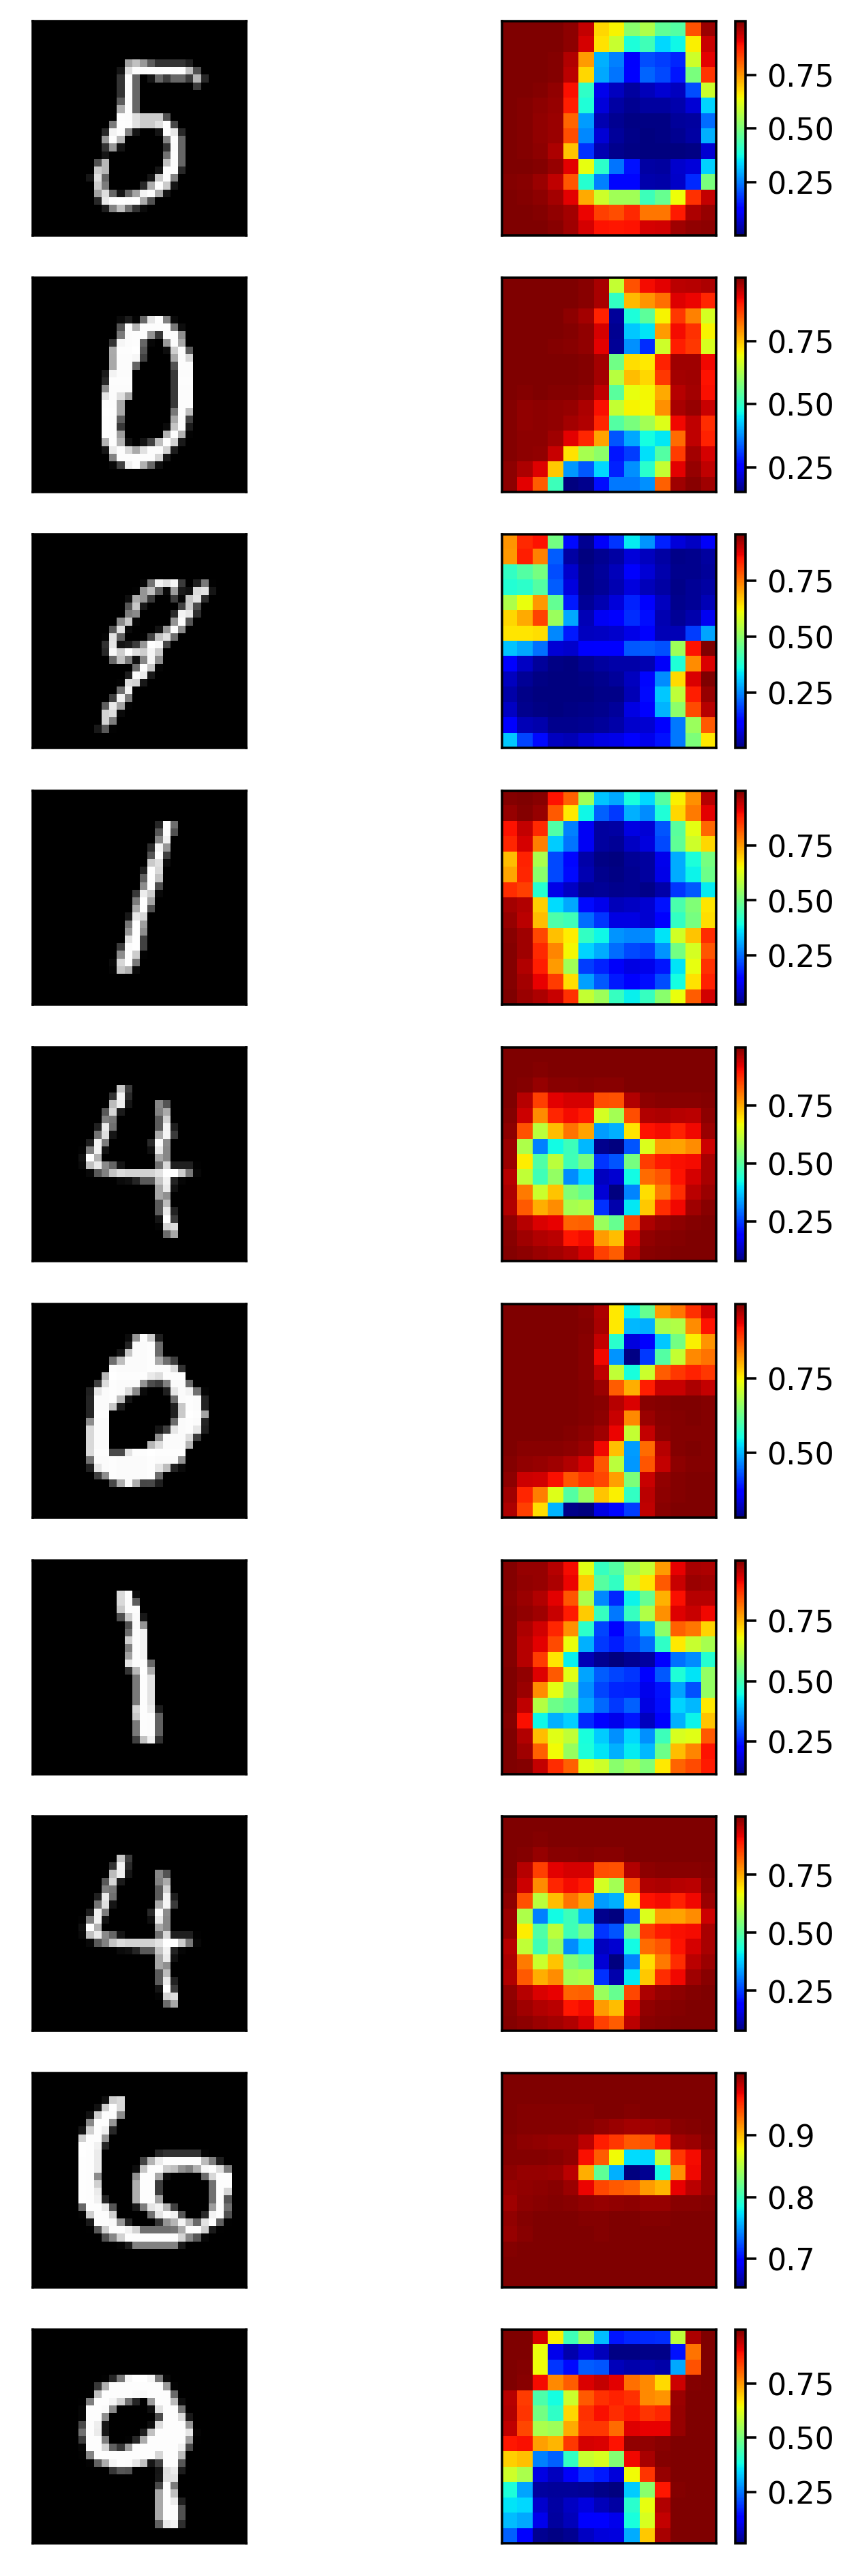

In [49]:
test_features, test_labels = next(iter(test_loader))
rand_samples = np.random.choice(test_features.shape[0],10)
siz = 14
prob = np.zeros((len(range(0,28-siz)),len(range(0,28-siz)),10))

for i in range(0,28-siz):
    for j in range(0,28-siz):
        for k in range(10):
            temp = torch.clone(test_features[rand_samples[k]].reshape(28,28))
            temp[i:i+siz,j:j+siz] = torch.from_numpy(np.full((siz,siz),1))
            prob[i,j,k]=model.forward(temp.reshape(1,1,28,28).cuda())[0][test_labels[rand_samples[k]].argmax().item()].item()
fig , axs = plt.subplots(10,2,figsize=(5, 15),dpi=320)
k=0
for i in range(10):
    
    axs[i,0].xaxis.set_visible(False)
    axs[i,0].yaxis.set_visible(False)
    axs[i,0].imshow(test_features[rand_samples[i]].reshape(28,28),  cmap="gray")
    axs[i,1].xaxis.set_visible(False)
    axs[i,1].yaxis.set_visible(False)
    im = axs[i,1].imshow(prob[:,:,i],cmap='jet')
    plt.colorbar(im, ax = axs[i,1])
k+=1

#### Results:

* Increasing the patch size from 7X7 to 14X14 makes huge difference the patch is now effectivelt covering enough part of the digit simultaneouly for the model to get confused.

* This makes sense given that original image are 28X28 which basically means we are covering 1/4th of the image pixel and model works with only 75% of the image data for the prediction.

* We can see model is still able to work but it just has a hard time working with the occulusion patch.

* Digit 6 loop is important distinction for model to predict the digit we see it lose confidence there.

* Digit 9 is a hard digit to learn because of its complex feature and the 3rd image for digit 9 shows the many way we can write it and some forms of a digit are harder to predict then others.

* Similarly for digit like 4 they can be confused between other digit like 9 based on where the patch is currently on the image.

# Adversial Attack

In [ ]:
model.load_state_dict(torch.load('best.ckpt'))

In [218]:
model.to(torch.device("cpu"))

MNISTCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (activ): ReLU()
  (softmax): Softmax(dim=1)
)

In [219]:
X = torch.from_numpy(np.random.normal(loc = 128, scale = 10,size=(28, 28))).reshape(1,1,28,28).float()

In [220]:
base_pred = model.forward(X)

## Non-Targeted Attack

* Lets build the idea to attack the model.

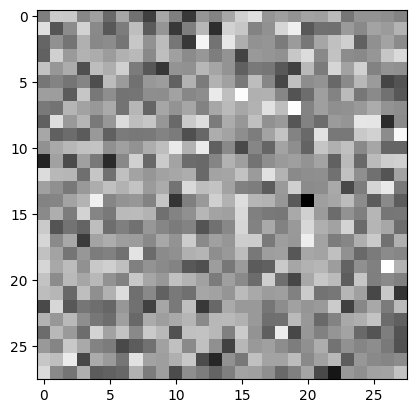

In [221]:
plt.imshow(X.detach().numpy().reshape(28,28),cmap='gray')

* We have generated a sample from numpy normal distribution centered around 128. The sample generated is same size as the image we trained the model on.

* This time around we will be trying to train the image for our model instead of the model to the image.

* We will now try to optimize this image to be predicted as one of the target label in our model. To do so we will pass this image to the model and use the logit function defined earlier to get output before the last softmax layer and fix that as the cost for this image.

* So basically a higher value for cost is a higher probability of this image being that target class so our ideas here is to maximize the cost so we get more confidence from the model as the class we are trying to make the model predict.

In [247]:

from torch.autograd import Variable
def non_target_adv_gen(X,target,epoch,rate):
    cost_track = []
    for i in range(epoch):
        X = Variable(X,requires_grad=True)
        c = cost(X,target)
        cost_track.append(c.item())
        c.backward(retain_graph=True)
        X = X + rate * X.grad
    confidence = model.forward(X)[0][target].item()
    return X,confidence,cost_track
def cost(X,target):
    return model.logits(X)[0][target]

### Given above is the function we would be using this function optimize the image to fit a target label using backpropagation.

In [223]:
target = 3
res,con,cost_track = non_target_adv_gen(X,target = target,epoch = 1000,rate = 0.6)
print(con)

1.0


In [224]:
print(base_pred)
print(model.forward(res))

print("Targeted Class :" + str(target))
print("Predicted Class :" + str(model.forward(res).argmax().item()))
print("Noise Class :" + str(base_pred.argmax().item()))

tensor([[4.6393e-19, 1.0000e+00, 1.1033e-34, 1.7353e-33, 1.3987e-31, 0.0000e+00,
         1.3071e-31, 0.0000e+00, 6.9711e-22, 0.0000e+00]],
       grad_fn=<SoftmaxBackward0>)
tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], grad_fn=<SoftmaxBackward0>)
Targeted Class :3
Predicted Class :3
Noise Class :1


### Results:

* For an individual digit lets say 3. if we try to fit this random sample to be predicted as 3 we see the sample tries to take some sort of inherent strucure which looks really similar to 3.

* We can see that a random sample warps into a structure to look similar to 3 to fool the network.

* Plotting the cost for this we see how the image is being optimized over 1000 iteration and cost increase as the confidence of the model increases in the image.

Targeted Class is : 3


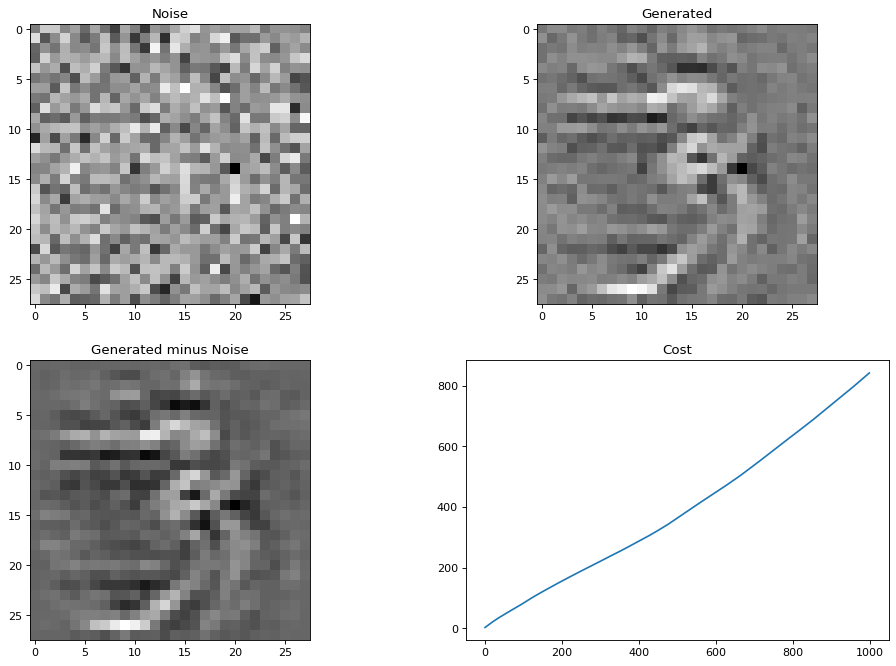

In [225]:
fig , axs = plt.subplots(2,2,figsize=(15, 10),dpi=80)
print("Targeted Class is :",target)
axs[0,0].imshow(X.detach().numpy().reshape(28,28),cmap='gray')
axs[0,0].title.set_text("Noise")
axs[0,1].imshow(res.detach().numpy().reshape(28,28),cmap='gray')
axs[0,1].title.set_text("Generated")
axs[1,0].imshow((res.detach().numpy()-X.detach().numpy()).reshape(28,28),cmap='jet')
axs[1,0].title.set_text("Generated minus Noise")
axs[1,1].plot(cost_track)
axs[1,1].title.set_text("Cost")

### Results for each 0 to 9 digit to see how the model imagines each digit as:

* I have added another image as a original sample - trained to see what exactly changed.

* We can see some feature pop up which looks similar to how those digit look. This is apparent in lot of these digit for exam in digit 0,1 and 3.

* For digit 4 we can see the model gets good confidence is still quite distorted image. This is mostly likely due the fact that different types of way to write 4 and also how it looks similar to 9 so the distinct feature to classify something as 4 is bit harder which is observable in its output.

* Digit with loops or curve we can see curves appreaing in their image generated like 6 and 9 and we can also see a slight cruve in top section of digit 5.

* All these observation are based on what all digit model was trained on. This makes the model trying to write the digit given a set of 60000 images to look at.

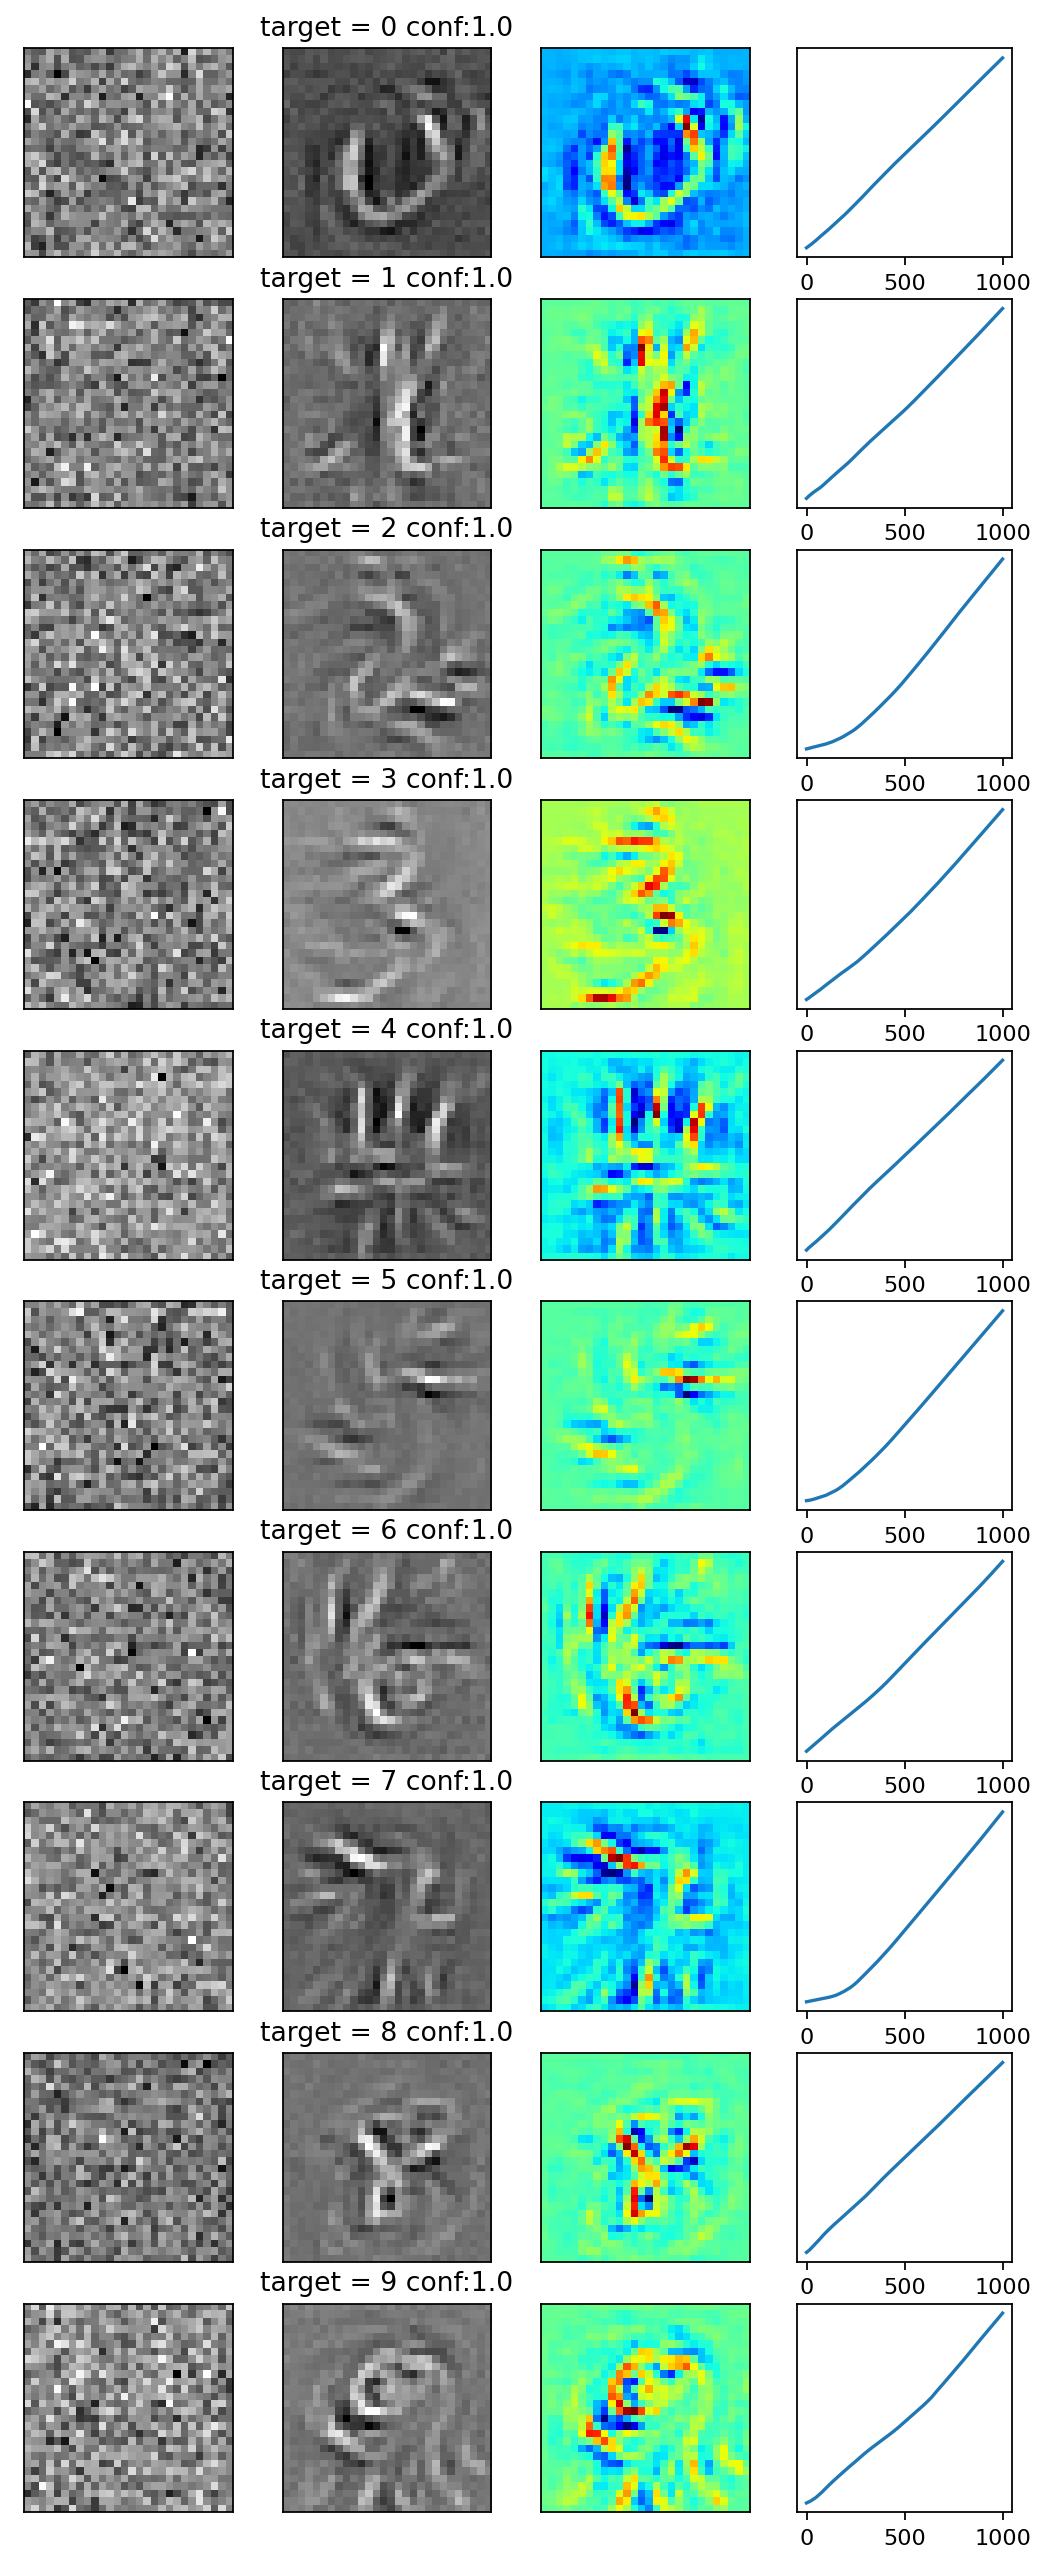

In [248]:
fig , axs = plt.subplots(10,4,figsize=(8, 20),dpi=160)
k=0
for i in range(10):
    
    X = torch.from_numpy(np.random.normal(loc = 128, scale = 10,size=(28, 28))).reshape(1,1,28,28).float()
    res,con,cost_track = non_target_adv_gen(X,target = i,epoch = 1000,rate = 1)
    
    axs[i,0].xaxis.set_visible(False)
    axs[i,0].yaxis.set_visible(False)
    axs[i,0].imshow(X.detach().numpy().reshape(28,28),cmap='gray')
    
    axs[i,1].xaxis.set_visible(False)
    axs[i,1].yaxis.set_visible(False)
    axs[i,1].imshow(res.detach().numpy().reshape(28,28),cmap='gray')
    axs[i,1].title.set_text("target = "+str(i)+" conf:" + str(round(con, 2)))
    
    axs[i,2].xaxis.set_visible(False)
    axs[i,2].yaxis.set_visible(False)
    axs[i,2].imshow((res.detach().numpy()-X.detach().numpy()).reshape(28,28),cmap='jet')
    
    axs[i,3].yaxis.set_visible(False)
    axs[i,3].plot(cost_track)

In [286]:
model.to(torch.device("cpu"))
test_features, test_labels = next(iter(test_loader))
rand_samples = np.random.choice(test_features.shape[0],10)

## Targetted Attack:

* In this section we will be trying to add noise to a image from the sample set and trying to change the prediction of the model from the original label of the image to a target label we want it to predict.

* This works as mentioned in the Assignment we are training a noise matrix of size 28X28 which is added to original image and optimized to predicted our targetted class instead of the original class.

In [323]:
def target_adv_gen(X,target,epoch,rate):
    
    N = torch.from_numpy(np.zeros((28,28))).reshape(1,28,28).float()
    cost_track = []
    
    for i in range(epoch):
        N = Variable(N,requires_grad=True)
        X_n = X + N
        c = cost(X_n.reshape(1,1,28,28),target)
        cost_track.append(c.item())
        c.backward(retain_graph=True)
        N = N + rate * N.grad
    confidence = model.forward(X_n.reshape(1,1,28,28))[0].max().item()
    return X_n,confidence,cost_track,N


### Results:

* Target x from y means original image was y and we tried to make its prediction into x.

* The images in order are True image with its label then the noise we added to it indivudually and then finally noise added to original image which was given to the model.

* We can see in the first example the original digit is 0 but the added noise optimized for target 2 fools the model completely as the model is confident in its prediction.

* But for some cases like target 6 from 2 and target 0 from 4. We can see when we tried to fool the model it did'nt work the model still detected the image as original label. This shows some digits are more resiliant to adversial targetted attack.

* Last example shows that our model was being fooled but we could get the confidence only upto 51% target 8 from 2

* Digit which look quite similar are easier to fool as it takes less noise to move from one prediction to another and this shows us the model is fooled easily for these digits. Like 4 to 7 or 5 to 6.

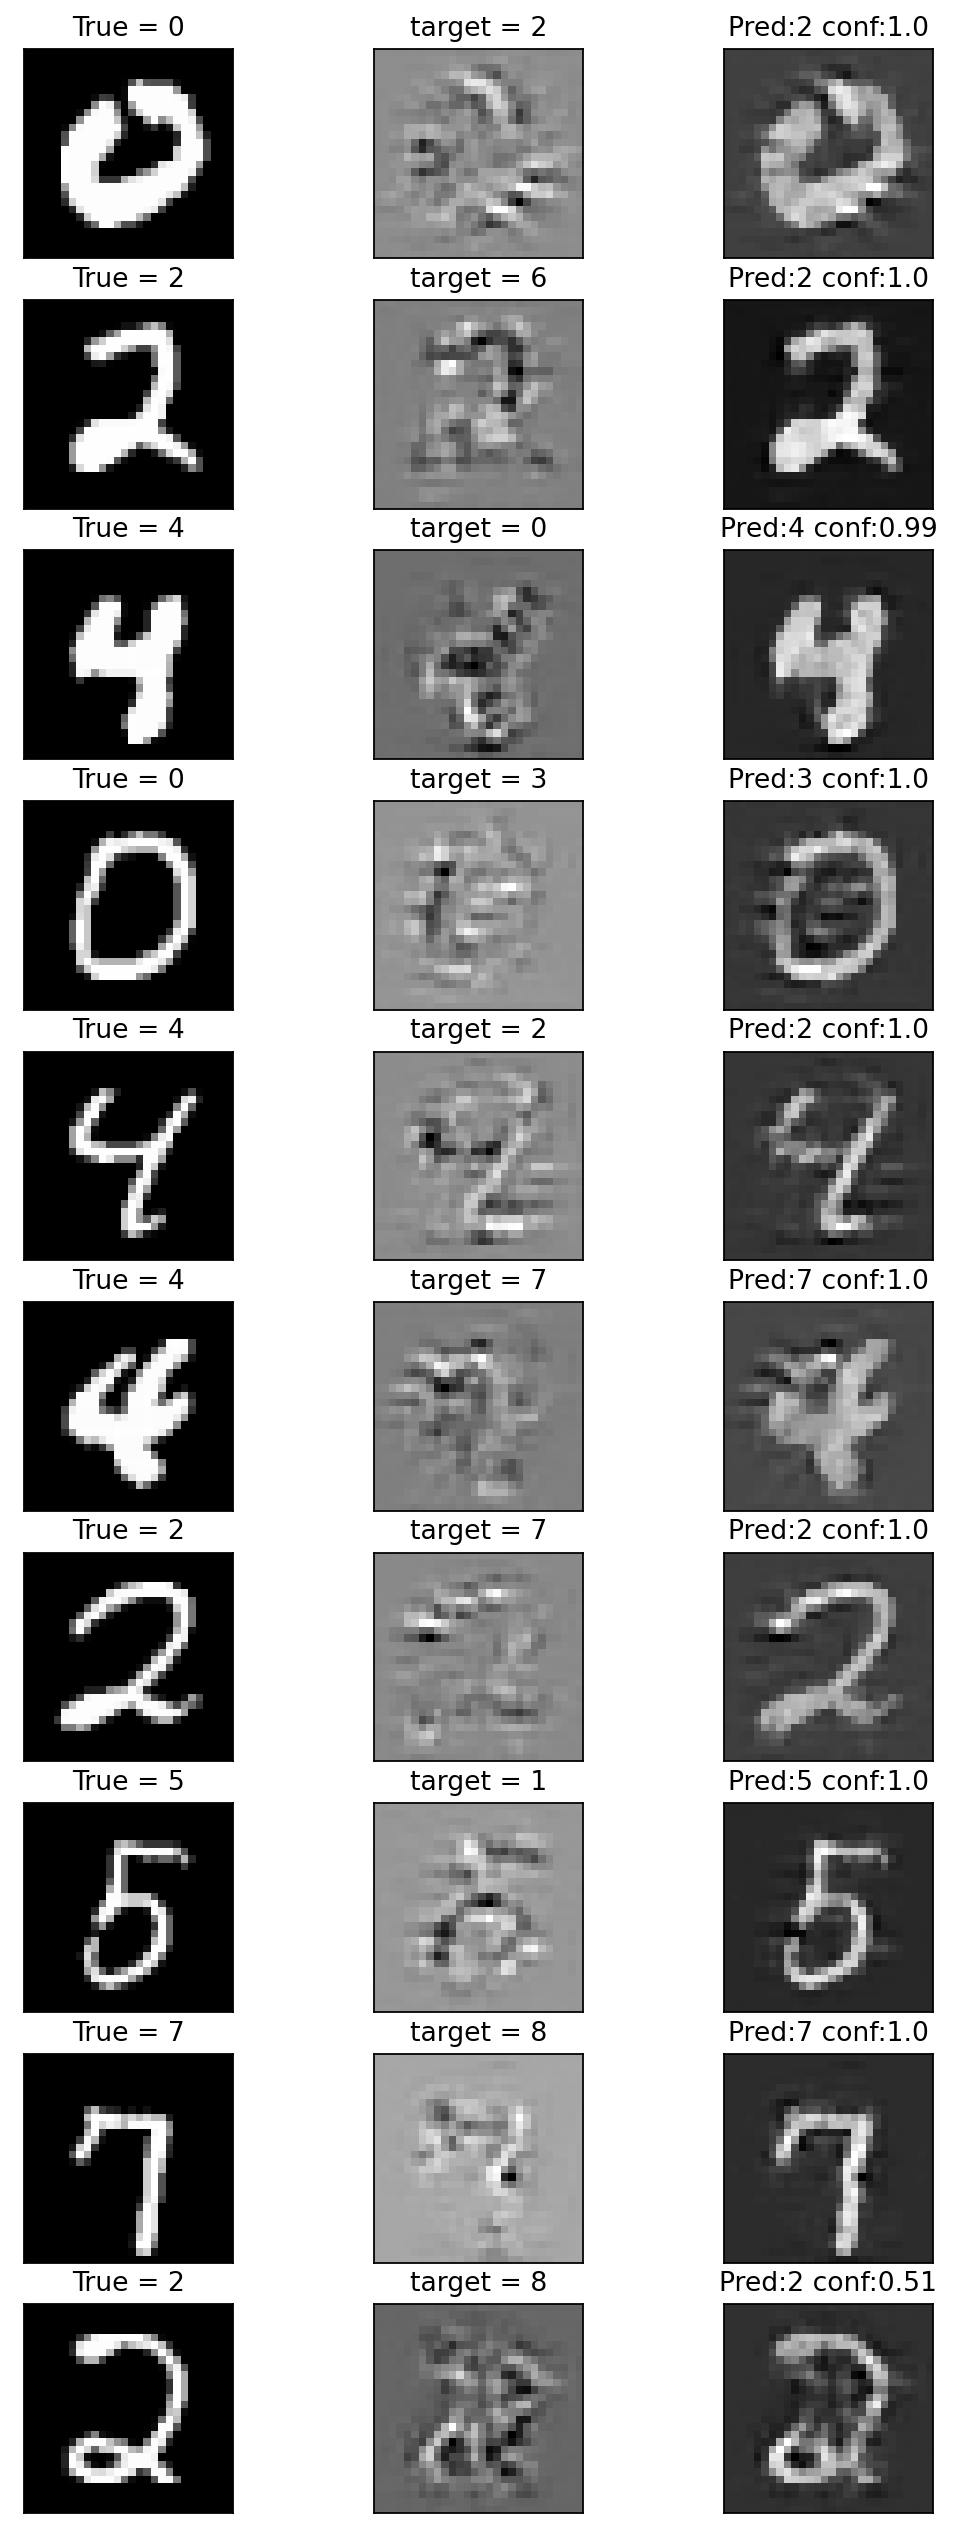

In [325]:
fig , axs = plt.subplots(10,3,figsize=(8, 20),dpi=160)
k=0
for i in range(10):
    
    X = test_features[rand_samples[i]]
    true_label = test_labels[rand_samples[i]].argmax().item()
    target = np.random.randint(low=0,high=9,size=(1,9))
    target = target[target != true_label]
    
    res,con,cost_track,noise = target_adv_gen(X,target = target[-1],epoch = 1000,rate = 0.01)
    
    axs[i,0].xaxis.set_visible(False)
    axs[i,0].yaxis.set_visible(False)
    axs[i,0].imshow(X.detach().numpy().reshape(28,28),cmap='gray')
    axs[i,0].title.set_text("True = "+str(true_label))
    
    axs[i,1].xaxis.set_visible(False)
    axs[i,1].yaxis.set_visible(False)
    axs[i,1].imshow(noise.detach().numpy().reshape(28,28),cmap='gray')
    axs[i,1].title.set_text("target = "+str(target[-1]))
    
    axs[i,2].xaxis.set_visible(False)
    axs[i,2].yaxis.set_visible(False)
    axs[i,2].imshow(res.detach().numpy().reshape(28,28),cmap='gray')
    axs[i,2].title.set_text("Pred:" + str(model.forward(res.reshape(1,1,28,28)).argmax().item()) + " conf:" + str(round(con, 2)))
    